[View in Colaboratory](https://colab.research.google.com/github/mzhang32/nanohub-project/blob/master/first_submodel.ipynb)

#First Submodel
Refer to the design document [here](https://docs.google.com/document/d/1BM18EP8cWlJ371yYBoru_q8MHjesn3eBKg7CYRqPmv0/edit). We're using GitHub to back up and Google Drive to collaborate. I believe this tool(Google Colab) will be useful because it is highly collaborative and easy to use.

In [0]:
# Currently not being used.
!pip install PyOpenGL PyOpenGL_accelerate


In [1]:
 !pip install shapely

    100% |████████████████████████████████| 1.5MB 6.5MB/s 




###Given a set of inputs about angle distribution and nanotube length and filament size, generate some line segments .


In [0]:
import numpy as np
import math
from shapely.geometry import LineString

#Find volume of polymer
def calc_volume(width_of_poly, length_of_poly):
    v = (width_of_poly ** 2) * length_of_poly
    return v
  
def execute(volume_fraction, width_of_poly, length_of_poly, diameter, 
            volume_of_poly, mean_nanowire_length, SD, theta_lower, 
            theta_upper, phi_lower, phi_upper):
    
    # Find Volume of Nanowire
    def wire_volume(length, diameter):
        volume = math.pi * ((diameter / 2) ** 2) * length
        return volume 

    # Creating a list of random starting points for number of desired 
    # nanowires in sim
    def get_initial_point():
        x = np.random.uniform(-(width_of_poly / 2), (width_of_poly / 2))
        y = np.random.uniform(0, length_of_poly)
        z = np.random.uniform(0, width_of_poly)
        g = [x, y, z]
        nonlocal start_points
        start_points.append(g)
        
    # Creating lists of random lengths and angles     
    def lengths_angles(theta_lower, theta_upper, phi_lower, phi_upper):
        length = np.random.normal(mean_nanowire_length, SD)
        lengths.append(length)
        horiz_angle = np.random.uniform(theta_lower, theta_upper)
        verti_angle = np.random.uniform(phi_lower, phi_upper)
        a = [horiz_angle, verti_angle]
        angles.append(a)
          
    def check_distance(start_points, end_points, line1, diameter):
        for start, end in zip(start_points, end_points):
            point1 = (start[0], start[1], start[2])
            point2 = (end[0], end[1], end[2])
            line2 = LineString([point1, point2])
            dis = line1.distance(line2)
            if line1.distance(line2) < diameter:
              return False
        return True

    # Creating list of respective end points using initial points, 
    # lengths & angles      
    def get_end_points(start_points, lengths, angles, width_of_poly, 
                       length_of_poly, diameter, intersect = True):
        nonlocal wires
        x = start_points[wires][0]
        y = start_points[wires][1]
        z = start_points[wires][2]        
        phi = angles[wires][0]
        theta = angles[wires][1]
        length = lengths[wires]
        x1 = x + length * math.sin(theta) * math.cos(phi)
        y1 = y + length * math.sin(theta) * math.sin(phi)
        z1 = z + length * math.cos(theta)
        line1 = LineString([(x, y, z), (x1, y1, z1)])    
        
        # Checks to make sure no internal creation
        if intersect == True: 
          if len(end_points) != 0:
              while check_distance(start_points, end_points, 
                                   line1, diameter) == False:
                  x = np.random.uniform(-(width_of_poly / 2), 
                                        (width_of_poly / 2))
                  y = np.random.uniform(0, length_of_poly)
                  z = np.random.uniform(0, width_of_poly)
                  g = [x, y, z]
                  start_points[wires] = g
                  x1 = x + length * math.sin(theta) * math.cos(phi)
                  y1 = y + length * math.sin(theta) * math.sin(phi)
                  z1 = z + length * math.cos(theta)      
                  line1 = LineString([(x, y, z), (x1, y1, z1)])    
        # Checks to make sure end points are in domain
        while y1 > length_of_poly or z1 > width_of_poly or z1 < 0 \
              or abs(x1) > (width_of_poly / 2):
            x = np.random.uniform(-(width_of_poly / 2), 
                                  (width_of_poly / 2))
            y = np.random.uniform(0, length_of_poly)
            z = np.random.uniform(0, width_of_poly)
            g = [x, y, z]
            start_points[wires] = g
            x1 = x + length * math.sin(theta) * math.cos(phi)
            y1 = y + length * math.sin(theta) * math.sin(phi)
            z1 = z + length * math.cos(theta)
        new = [x1, y1, z1]
        end_points.append(new)
        wires += 1    
        
    wires = 0
    volume = 0
    start_points = []
    lengths = []
    angles = []
    end_points = []
    
    while (volume / volume_of_poly) < volume_fraction:
        get_initial_point()
        lengths_angles(theta_lower, theta_upper, phi_lower, phi_upper)  
        get_end_points(start_points, lengths, angles, width_of_poly, 
                       length_of_poly, diameter)
        volume += wire_volume(lengths[-1], diameter)
        #print(wires)
    
    #print(volume)
    #print(wires)
    return start_points, end_points


In [0]:
# Generates about 2500 nanowires
volume_fraction = 1/100
width_of_poly = 25e-6
length_of_poly = 25e-6
diameter = 125e-9
volume_of_poly = calc_volume(width_of_poly, length_of_poly)
mean_nanowire_length = 5e-6
SD = 1.5e-6
theta_lower = 0
theta_upper = math.pi
phi_lower = 0
phi_upper = math.pi
start_points, end_points = execute(volume_fraction, width_of_poly, 
                                   length_of_poly, diameter, 
                                   volume_of_poly, mean_nanowire_length, 
                                   SD, theta_lower, theta_upper, 
                                   phi_lower, phi_upper)


In [9]:
# Testing LineString behavior
seg1 = LineString([(0, 0, 0), (1, 0, 0)])
seg2 = LineString([(2, 0, 0), (3, 0, 0)])
print(seg1.distance(seg2)) # Should be 1
seg3 = LineString([(0, 0, 1), (1, 0, 1)])
print(seg1.distance(seg3)) # Should be 1
seg4 = LineString([(0, -1, 0), (1, -1, 0)])
print(seg1.distance(seg4)) # Should be 1

1.0
0.0
1.0


In [0]:
print(len(start_points))
start_points

 ### Graphically visualize the model.
 We may have to import some libraries. A good-looking one is this python wrapper for OpenGL, [PyOpenGL](http://pyopengl.sourceforge.net/).
 
 It turns out using opengl in python notebook is not possible(?).

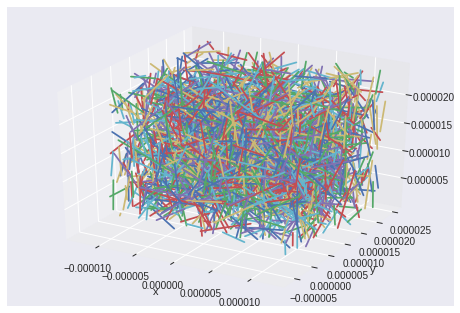

In [99]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

segments = []
for start, end in zip(start_points, end_points):
  x = [start[0], end[0]]
  y = [start[1], end[1]]
  z = [start[2], end[2]]
  segments.append([x, y, z])
for seg in segments:
  ax.plot(seg[0], seg[1], seg[2])
plt.xlabel('x')
plt.ylabel('y')  
#ax.plot([0, -1], [0, -1], [0, -1]) # Test line segment
plt.show()  


###Represent the distribution of the nanowires and the distances between them as a graph.
Let G = (V, E) where V is the set of indiviual nanowires and let E = (V1, V2), the distance between nanowires V1 and V2. Using the graph package library [NetworkX](https://networkx.github.io/documentation/stable/tutorial.html).

In [40]:
!pip install networkx

In [0]:
import networkx as nx

""" Returns a networkx graph G formed from V = the segments in format 
 [(x1, x2), (y1, y2), (z1, z2)] and E = distances between the segments 
 that are within tolerance.
"""
def init_graph(segments, tolerance):
  number_of_tubes = len(segments)
  G = nx.Graph()
  # Sort by the one of the segment's endpoint's y value.
  V = sorted(segments, key=lambda v: v[1][0]) 
  line_strings = [LineString([(seg[0][0], seg[1][0], seg[2][0]), 
                         (seg[0][1], seg[1][1], seg[2][1])]) for seg in V]

  G.add_nodes_from(range(number_of_tubes))

  # Generate a graph using distances as weights. Only adds edge if 
  # distance between segments is within tilerance. May need to optimize 
  # later.
  for i in range(number_of_tubes - 1):
    seg1 = V[i]
    line1 = line_strings[i]
    for j in range(i):
      seg2 = V[j]
      line2 = line_strings[j]
      d = line1.distance(line2)
      if d <= tolerance:
        G.add_edge(i, j, weight=line1.distance(line2))  
  return G
      
  

In [0]:
G = init_graph(segments, 0)
#G = init_graph(segments, diameter)
#list(G.nodes)

### Use the graph to compute a conductive path.
1. Graph theory is great. Details are in the working. The paper used the Union-Find Algorithm :
*"To find the conductive cluster in a nanotube system
between two electrodes and to calculate the probability of
percolation, an algorithm based on the graph theory is used.
According to the algorithm, all tubes of the system are
represented as vertices of a simple graph, edges of which
correspond to the connections between the tubes. Nanotubes
that are in contact with the opposite sides of the parallelepiped
form two subsets corresponding to the electrode. At the next
stage, a component that combines these subsets is sought by
means of the union-find algorithm. Thus, a conductive path in
the nanotubes system is formed.""* From [Computer Simulation of Field-Controlled Percolation
in 3D System of Straight Nanotubes](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8365699&tag=1).

2. Add in model for electrical conductivity of nanowires to calculate material properties in domain.


In [0]:
list(G.edges.data('weight'))

In [0]:
def is_between(b1, x, b2):
   return (b1 <= x and x <= b2) or (b2 <= x and x <= b1)

""" Given the length of the cross-section, a list of sorted segments 
 [(x1, x2), (y1, y2), (z1, z2)], graph G, and a tolerance, return a 
 connecting cluster from source(y~0) to sink(y~length). If none, 
 return None. 
"""
def find_connecting_cluster(length, segs, G, tol):
  source_plane = length/100
  sink_plane = length - length/100
  
  
  n = range(len(segs))
  source_segs = [i for i in n if is_between(segs[i][1][0], 
                                            source_plane, segs[i][1][1])]
  sink_segs = [i for i in n if is_between(segs[i][1][0], 
                                          sink_plane, segs[i][1][1])]
  
  if not source_segs or not sink_segs:
    print("No nanotubes intersecting source and/or sink planes.")
    return None
  
  # Iteratively grow the connecting cluster beginning from the source.
  H = nx.Graph()
  H.add_nodes_from(source_segs)
  new_segs = source_segs
  while new_segs:
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in G.neighbors(seg):
        if v not in sink_segs and v not in H.nodes:
          new_segs.append(v)
        H.add_edge(seg, v, weight=G[seg][v]['weight'])  
  
  # Iteratively grow from the sink to get the final cluster.
  K = nx.Graph()
  new_segs = [v for v in H.nodes if v in sink_segs]
  K.add_nodes_from(new_segs)
  while new_segs:
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in H.neighbors(seg):
        if v not in source_segs and v not in K.nodes:
          new_segs.append(v)
        K.add_edge(seg, v, weight=G[seg][v]['weight'])  
  return K
          
  
  

In [0]:
import random

""" Given the length of the cross-section, a list of sorted segments 
 [(x1, x2), (y1, y2), (z1, z2)], graph G, and a tolerance, return a 
 connecting graph. If none, return None. 
"""
def find_connecting_path(length, segs, G, tol):

  source_plane = length/100
  sink_plane = length - length/100

  H = nx.Graph()
  #X = UnionFind()

  def is_between(b1, x, b2):
    return (b1 <= x and x <= b2) or (b2 <= x and x <= b1)
    

  n = range(len(segs))
  source_segs = [i for i in n if is_between(segs[i][1][0], 
                                            source_plane, segs[i][1][1])]
  sink_segs = [i for i in n if is_between(segs[i][1][0], 
                                          sink_plane, segs[i][1][1])]
  random.shuffle(source_segs)
  random.shuffle(sink_segs)
  
  print("Source segments: ", source_segs)
  print("Sink segments: ", sink_segs)
  if not source_segs or not sink_segs:
    print("No nanotubes intersecting source and/or sink planes.")
    return None
  
  H.add_nodes_from(source_segs)
  #X.union(source_segs)
  sink = None
  new_segs = source_segs
  while new_segs:
    # Add contacting tubes to each set.  
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in G.neighbors(seg):
        if v not in source_segs:
          #X.union(source_segs[0], v)
          new_segs.append(v)
          H.add_edge(seg, v, weight=G[seg][v]['weight'])
          if v in sink_segs:
            sink = v
            return H, sink, source_segs
            

  
  print("No connecting path found.")
  return None
 
"""Returns a path from source to sink given a graph H. """
def get_paths_from_components(H, sink, source_segs):
  ccs = list(nx.connected_components(H))
  # path = max(ccs, key=lambda c:len(c))
  paths = []
  for component in sorted(ccs, key=lambda c:len(c), reverse=True):
    if sink in component:
      for node in component:
        if node in source_segs and nx.has_path(H, node, sink):
          #p = nx.shortest_path(H, node, sink)
          p = nx.all_simple_paths(H, node, sink)
          paths.extend(p)
          #paths.append(p)
  return paths        
    



In [132]:
H, sink, source_segs = find_connecting_path(length_of_poly, segments, G, diameter)
# Getting a path from the cluster
paths = get_paths_from_components(H, sink, source_segs)
for p in paths:
  print(p)
#print("The path: ", path)

#list(H.edges)


Source segments:  [304, 157, 1673, 918, 965, 11, 1507, 566, 60, 56, 580, 419, 963, 27, 410, 1877, 7, 801, 832, 1624, 1546, 350, 1638, 905, 48, 1922, 193, 1118, 1791, 1864, 1547, 74, 159, 1163, 2137, 181, 771, 1172, 839, 1335, 1495, 1218, 5, 859, 1061, 2430, 658]
Sink segments:  [1321, 1020, 2327, 145, 1466, 1709, 1022, 1000, 403, 2268, 574, 1376, 1942, 1383, 1433, 950, 1591, 1867, 1037, 2259, 166, 2002, 1838, 796, 515, 2394, 1421, 1648, 429, 983, 2526, 871, 1951, 1938, 1860, 246, 1138]
[918, 950]


###Graphically visualize the model with a path.

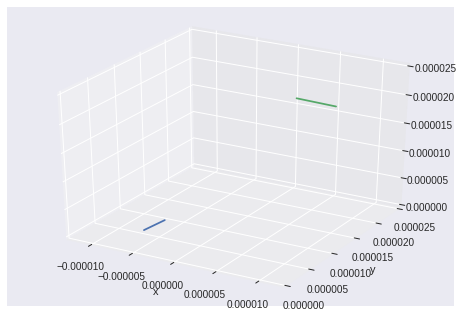

Segment 11 to 429 has weight 0.000000.
The path consists of the following segments: 
[[-2.316537532237015e-06, -1.8678002444235162e-06], [1.8615412887712264e-06, -2.852909572519425e-06], [5.194780025871829e-06, 6.1521612198585655e-06]]
[[6.358035286036809e-06, 2.650544282972828e-07], [2.2297630404273227e-05, 2.4863564623275657e-05], [1.7677886959518005e-05, 1.6317733629073418e-05]]


In [98]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n in path:
  seg = segments[n]
  ax.plot(seg[0], seg[1], seg[2])
#ax.plot([0, -1], [0, -1], [0, -1]) # Test line segment
plt.xlabel('x')
plt.ylabel('y')
#plt.axis([-width_of_poly/2, width_of_poly/2, 0, length_of_poly, 0, length_of_poly])
ax.set_xlim3d(-width_of_poly/2, width_of_poly/2)
ax.set_ylim3d(0, length_of_poly)
ax.set_zlim3d(0, length_of_poly)
plt.show()  

for i in range(len(path)-1):
  u = path[i]
  v = path[i+1]
  print("Segment %d to %d has weight %f." % (u, v, H.edges[u, v]['weight']))
print("The path consists of the following segments: ")
for n in path:
  print(segments[n])
